Loaded 56897 NPY files from 2 directories
Total unique embedding arrays: 56897
Combined reference data: 56898 entries
Entries with matching embeddings: 56897
Unique embedding files matched: 56897
Original class distribution: {'ger': np.int64(114), 'australia': np.int64(345), 'health': np.int64(711), 'hsrd': np.int64(3512), 'enl': np.int64(3727), 'sew': np.int64(5672), 'europe': np.int64(6178), 'arroyo': np.int64(8933), 'paf': np.int64(9527), 'nsrd': np.int64(18178)}
Smallest class: ger with 114 samples
Second smallest class: australia with 345 samples
Will keep all samples for 'ger' and downsample others to 345
Final class distribution after custom balancing: {'australia': np.int64(345), 'sew': np.int64(345), 'enl': np.int64(345), 'nsrd': np.int64(345), 'paf': np.int64(345), 'arroyo': np.int64(345), 'hsrd': np.int64(345), 'health': np.int64(345), 'europe': np.int64(345), 'ger': np.int64(114)}
Prepared data matrix with shape: (3219, 3072)

Final distribution of divisions in analysis dat

/var/folders/sm/g41yr56s2795xl1qpfykx3dx6jwh7v/T/ipykernel_19729/4012987627.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_divisions))


/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/ref/plots/Division custom_balanced_dimension_reduction_20250323_164229.png
Plot saved to: /Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/ref/plots/Division custom_balanced_dimension_reduction_20250323_164229.png


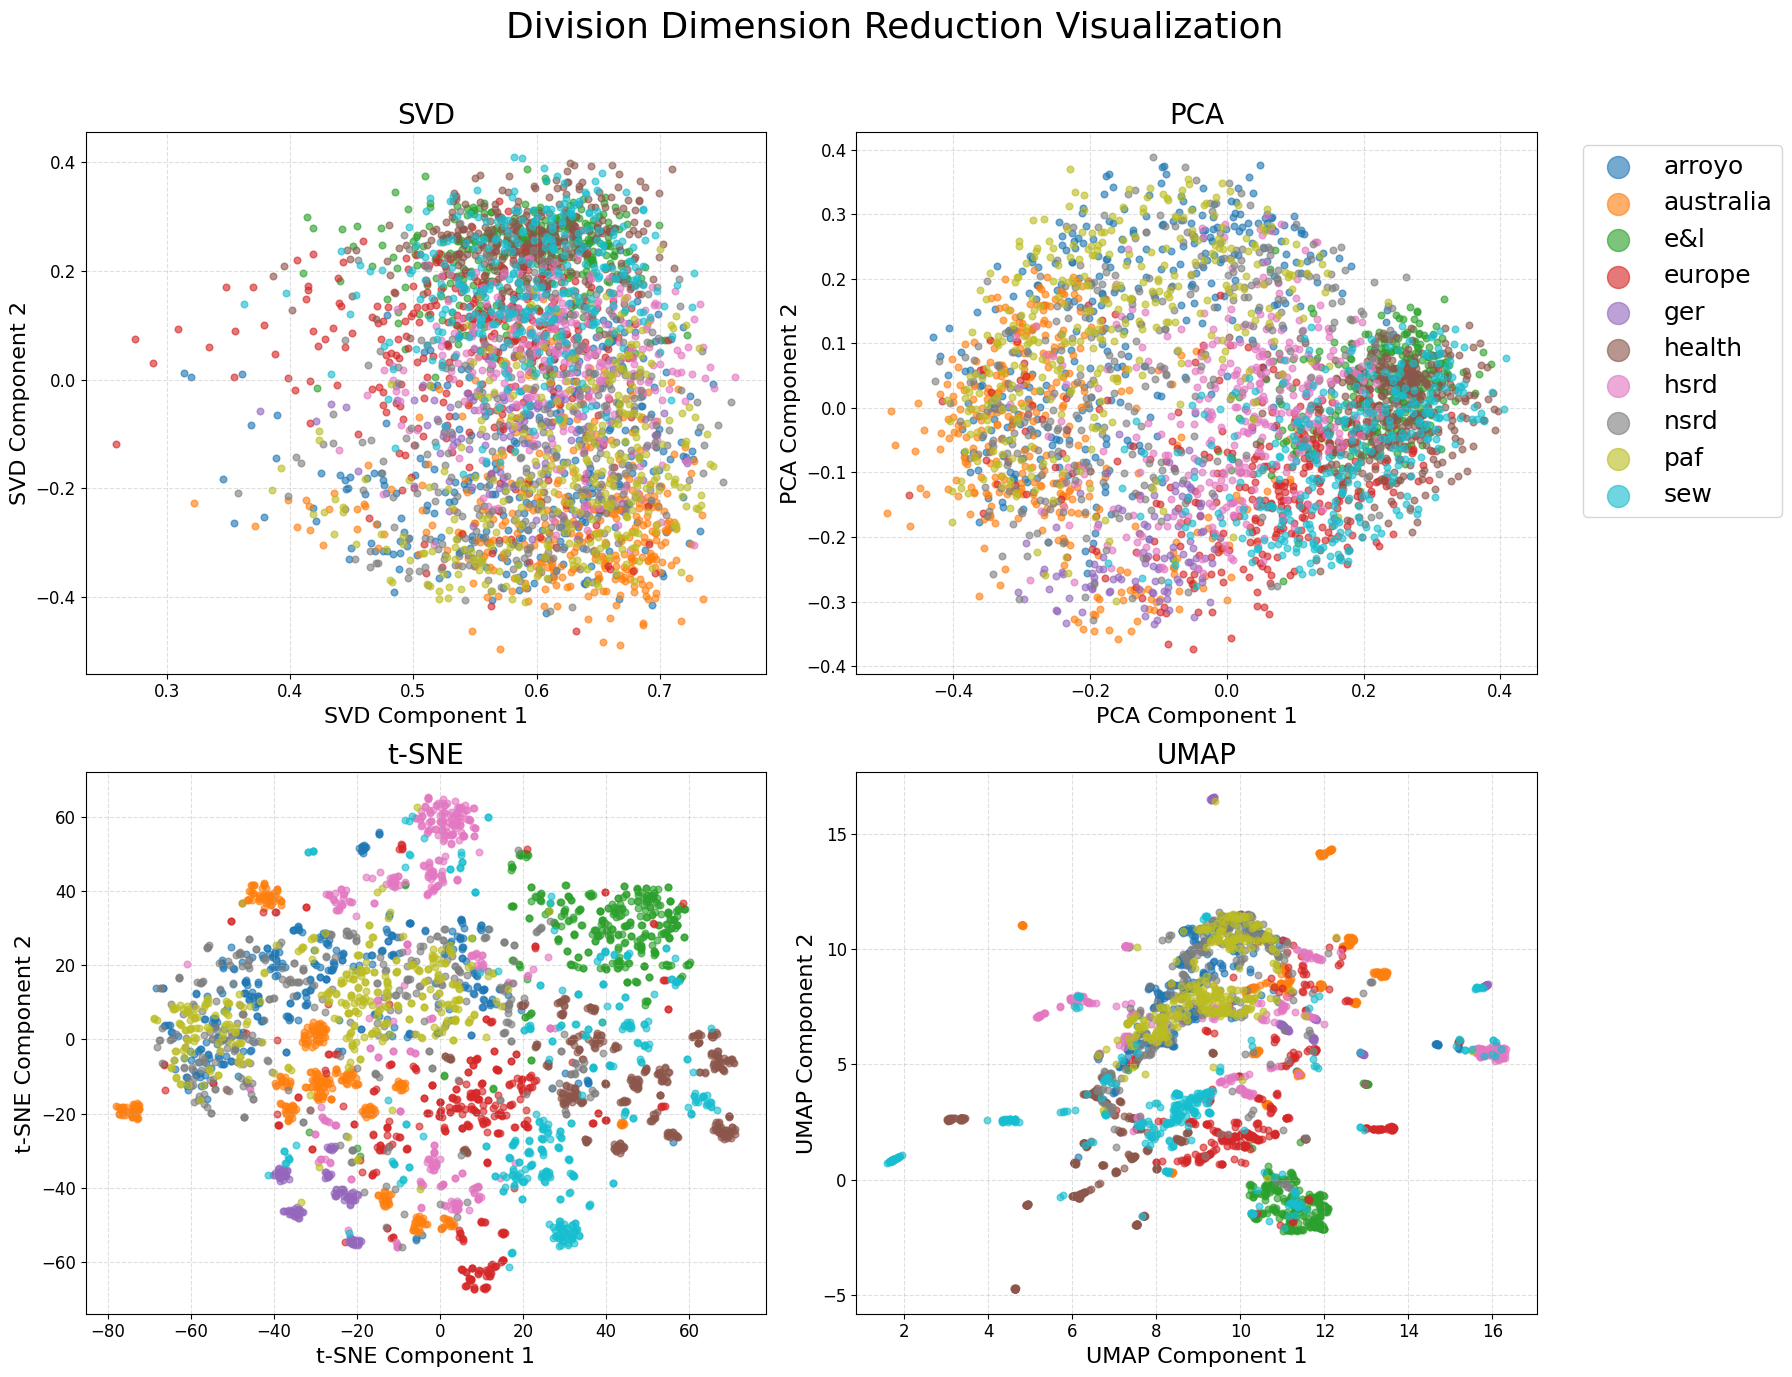

Data cached to: /Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/ref/cache/prepared_data_custom_balanced_1_20250323_164231.pkl


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap
import glob
from matplotlib.colors import to_rgba
from sklearn.utils import resample
import pickle
import hashlib
from datetime import datetime
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, squareform

# Function to load all npy files from multiple directories
def load_npy_files_from_multiple_dirs(directories):
    arrays = {}
    total_files = 0
    
    for directory in directories:
        npy_files = glob.glob(os.path.join(directory, "*.npy"))
        for file_path in npy_files:
            file_name = os.path.basename(file_path)
            key = file_name.split(".npy")[0]
            arrays[key] = np.load(file_path)
            total_files += 1
    
    print(f"Loaded {total_files} NPY files from {len(directories)} directories")
    print(f"Total unique embedding arrays: {len(arrays)}")
    return arrays

# Function to prepare data with custom downsampling strategy
def prepare_data_from_multiple_refs(arrays, reference_csv_paths, balance_classes=True):
    # Concatenate all reference CSVs
    dfs = []
    for csv_path in reference_csv_paths:
        df = pd.read_csv(csv_path)
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    # Remove duplicates if any
    combined_df = combined_df.drop_duplicates(subset=['hash'])
    
    print(f"Combined reference data: {combined_df.shape[0]} entries")
    
    # Filter to only include hashes that we have embeddings for
    loaded_files = arrays.keys()
    filtered_df = combined_df[combined_df['hash'].isin(loaded_files)]
    print(f"Entries with matching embeddings: {filtered_df.shape[0]}")
    
    data_df = pd.DataFrame({
        'file_name': [hash_val for hash_val in filtered_df['hash'] if hash_val in arrays],
        'div': [div for hash_val, div in zip(filtered_df['hash'], filtered_df['div']) if hash_val in arrays]
    })
    
    # Check how many unique embedding files were matched
    print(f"Unique embedding files matched: {len(data_df['file_name'].unique())}")
    
    if balance_classes:
        class_counts = data_df['div'].value_counts().sort_values()
        print(f"Original class distribution: {dict(class_counts)}")
        
        # Get the second smallest class count
        if len(class_counts) >= 2:
            second_smallest_count = class_counts.iloc[1]
            smallest_class = class_counts.index[0]
            print(f"Smallest class: {smallest_class} with {class_counts.iloc[0]} samples")
            print(f"Second smallest class: {class_counts.index[1]} with {second_smallest_count} samples")
            print(f"Will keep all samples for '{smallest_class}' and downsample others to {second_smallest_count}")
            
            downsampled_dfs = []
            
            # Keep all samples for the smallest class
            smallest_df = data_df[data_df['div'] == smallest_class]
            downsampled_dfs.append(smallest_df)
            
            # Downsample all other classes to match the second smallest
            for cls in class_counts.index[1:]:
                cls_df = data_df[data_df['div'] == cls]
                if len(cls_df) > second_smallest_count:
                    cls_df = resample(cls_df, replace=False, n_samples=second_smallest_count, random_state=42)
                downsampled_dfs.append(cls_df)
            
            data_df = pd.concat(downsampled_dfs)
            data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
            
            # Print the final class distribution
            final_counts = data_df['div'].value_counts()
            print(f"Final class distribution after custom balancing: {dict(final_counts)}")
        else:
            print("Only one class found, no balancing necessary")
    
    X, labels, file_names = [], [], []
    for _, row in data_df.iterrows():
        file_name = row['file_name']
        if file_name in arrays:
            X.append(arrays[file_name])
            labels.append(row['div'])
            file_names.append(file_name)
    
    X = np.vstack(X)
    print(f"Prepared data matrix with shape: {X.shape}")
    return X, labels, file_names

# Function to calculate cosine similarity distances within and between groups
def calculate_cosine_distances(X, labels):
    unique_labels = list(set(labels))
    indices_by_group = {label: [] for label in unique_labels}
    for i, label in enumerate(labels):
        indices_by_group[label].append(i)
    
    within_group_distances = {}
    between_group_distances = {}
    dist_matrix = squareform(pdist(X, metric='cosine'))
    
    for label in unique_labels:
        group_indices = indices_by_group[label]
        if len(group_indices) <= 1:
            within_group_distances[label] = 0
            continue
        within_distances = []
        for i, idx1 in enumerate(group_indices):
            for idx2 in group_indices[i+1:]:
                within_distances.append(dist_matrix[idx1, idx2])
        within_group_distances[label] = np.mean(within_distances)
    
    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i+1:]:
            group1_indices = indices_by_group[label1]
            group2_indices = indices_by_group[label2]
            between_distances = []
            for idx1 in group1_indices:
                for idx2 in group2_indices:
                    between_distances.append(dist_matrix[idx1, idx2])
            pair_key = f"{label1}-{label2}"
            between_group_distances[pair_key] = np.mean(between_distances)
    
    avg_within = np.mean(list(within_group_distances.values()))
    avg_between = np.mean(list(between_group_distances.values()))
    
    return {
        'within_group': within_group_distances,
        'between_group': between_group_distances,
        'avg_within': avg_within,
        'avg_between': avg_between
    }

# Generate a unique cache key based on input data and parameters
def generate_cache_key(X, method_name, balance_classes):
    data_hash = hashlib.md5(X.tobytes()).hexdigest()
    return f"{method_name}_{data_hash}_custom_balanced_{int(balance_classes)}"

# Function to apply dimension reduction techniques with caching
def apply_dimension_reduction(X, cache_dir, balance_classes=True):
    results = {}
    os.makedirs(cache_dir, exist_ok=True)
    
    methods = {
        'SVD': lambda: TruncatedSVD(n_components=2, random_state=42).fit_transform(X),
        'PCA': lambda: PCA(n_components=2, random_state=42).fit_transform(X),
        't-SNE': lambda: TSNE(n_components=2, random_state=42, perplexity=min(30, X.shape[0]-1)).fit_transform(X),
        'UMAP': lambda: umap.UMAP(random_state=42, n_neighbors=min(15, X.shape[0]-1)).fit_transform(X)
    }
    
    for method_name in methods:
        cache_key = generate_cache_key(X, method_name, balance_classes)
        cache_file = os.path.join(cache_dir, f"{cache_key}.pkl")
        
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                results[method_name] = pickle.load(f)
        else:
            reduced_data = methods[method_name]()
            with open(cache_file, 'wb') as f:
                pickle.dump(reduced_data, f)
            results[method_name] = reduced_data
    
    return results

# Function to plot the dimension reduction results
def plot_results(results, labels, title_prefix="", output_dir="/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/partisan/ref/plots", distance_metrics=None, legend_rename=None):
    os.makedirs(output_dir, exist_ok=True)
    unique_divisions = sorted(list(set(labels)))
    cmap = plt.cm.get_cmap('tab10', len(unique_divisions))
    color_map = {div: cmap(i) for i, div in enumerate(unique_divisions)}
    
    # Apply legend renaming if provided
    legend_labels = {}
    for div in unique_divisions:
        if legend_rename and div in legend_rename:
            legend_labels[div] = legend_rename[div]
        else:
            legend_labels[div] = div
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f"{title_prefix}Dimension Reduction Visualization", fontsize=26)
    axs = axs.flatten()
    
    for i, (method, reduced_data) in enumerate(results.items()):
        ax = axs[i]
        for division in unique_divisions:
            indices = [j for j, l in enumerate(labels) if l == division]
            ax.scatter(
                reduced_data[indices, 0],
                reduced_data[indices, 1],
                c=[color_map[division]],
                # Use the renamed label in the legend
                label=legend_labels[division],
                alpha=0.62,
                s=23
            )
        ax.set_title(f"{method}", fontsize=20)
        if i == 1:  # Only show legend on the last plot to avoid clutter
            ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc='upper left',
                      markerscale=3.3)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xlabel(f"{method} Component 1", fontsize=16)
        ax.set_ylabel(f"{method} Component 2", fontsize=16)
        ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f"{title_prefix}custom_balanced_dimension_reduction_{timestamp}.png")
    print(output_path)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_path}")
    plt.show()

# Main function to run the analysis with multiple input sources
# Updated main function with legend_rename parameter
def main(npy_directories, reference_csv_paths, output_prefix="", balance_classes=True, 
         cache_dir="dim_reduction_cache", plot_dir="plots", legend_rename=None):
    # Load all embedding arrays from multiple directories
    arrays = load_npy_files_from_multiple_dirs(npy_directories)
    if not arrays:
        print("No NPY files found.")
        return
    
    # Prepare data using combined reference CSVs with custom balancing
    X, labels, file_names = prepare_data_from_multiple_refs(arrays, reference_csv_paths, balance_classes)
    if len(labels) == 0:
        print("No matching files found.")
        return
    
    div_counts = pd.Series(labels).value_counts()
    print("\nFinal distribution of divisions in analysis data:")
    for div, count in div_counts.items():
        renamed_label = legend_rename.get(div, div) if legend_rename else div
        print(f"  {div} (displayed as '{renamed_label}'): {count} files")
    
    distance_metrics = calculate_cosine_distances(X, labels)
    print("\nCosine Distance Metrics:")
    print("Within-Group Distances:")
    for group, distance in distance_metrics['within_group'].items():
        renamed_group = legend_rename.get(group, group) if legend_rename else group
        print(f"  {group} ('{renamed_group}'): {distance:.4f}")
    print("\nBetween-Group Distances:")
    for pair, distance in distance_metrics['between_group'].items():
        group1, group2 = pair.split('-')
        renamed_group1 = legend_rename.get(group1, group1) if legend_rename else group1
        renamed_group2 = legend_rename.get(group2, group2) if legend_rename else group2
        print(f"  {group1}-{group2} ('{renamed_group1}'-'{renamed_group2}'): {distance:.4f}")
    print(f"\nAverage Within: {distance_metrics['avg_within']:.4f}")
    print(f"Average Between: {distance_metrics['avg_between']:.4f}")
    
    results = apply_dimension_reduction(X, cache_dir, balance_classes)
    plot_results(results, labels, title_prefix=output_prefix, output_dir=plot_dir, 
                legend_rename=legend_rename)
    
    # Save the prepared data for future use
    os.makedirs(cache_dir, exist_ok=True)
    data_cache_file = os.path.join(cache_dir, f"prepared_data_custom_balanced_{int(balance_classes)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl")
    with open(data_cache_file, 'wb') as f:
        pickle.dump({'X': X, 'labels': labels, 'file_names': file_names}, f)
    print(f"Data cached to: {data_cache_file}")
    
    return {
        'data': X,
        'labels': labels,
        'file_names': file_names,
        'results': results,
        'distance_metrics': distance_metrics
    }

# Example usage - update these paths with your actual directories and files
if __name__ == "__main__":
    # List of directories containing NPY files
    npy_directories = [
        "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/embeddings/real",
        "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/embeddings/real_ger"
    ]
    
    # List of reference CSV files
    reference_csv_paths = [
        "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/proc/ref/hash_chunks.csv",
        "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/proc/ref_ger/hash_chunks.csv"
    ]
    
    output_prefix = "Division "
    cache_dir = "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/ref/cache"
    plot_dir = "/Users/jmatveyenko/Documents/JM_RAND/PRGS/420 Text Analysis/Data/rand/ref/plots"
    
    legend_rename = {
        'enl': 'e&l'
    }
    results = main(npy_directories, reference_csv_paths, output_prefix, 
                  balance_classes=True, cache_dir=cache_dir, plot_dir=plot_dir, legend_rename=legend_rename)